## Bayesian Optimization Visualizer

In [39]:
from bayes_opt import BayesianOptimization
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
from bayes_opt.util import load_logs

# Bounded region of parameter space
pbounds = {'R': (0.0001, 0.1), 'B': (2.0, 6.0)}


def score_function(R, B):
    env = env_initialization(R, B)
    cum_reward = 0
    for t in range(5000):
        action = get_next_action(env, env.env_graph, coordinated_planner=False)
        _, reward, done, _ = env.step(action)
        cum_reward += reward
    return cum_reward

optimizer = BayesianOptimization(
    f=score_function,
    pbounds=pbounds,
    random_state=1,
    )

load_logs(optimizer, logs=["/Users/pehuen/Documents/ucla/LEMUR/warehouse_rrl/bayes_opt_logs2.json"])

In [44]:
import numpy as np
import pandas as pd

R_obs += np.array([[res["params"]["R"]] for res in optimizer.res]).flatten().tolist()
B_obs += np.array([[res["params"]["B"]] for res in optimizer.res]).flatten().tolist()
y_obs += np.array([[res["target"] for res in optimizer.res]]).flatten().tolist()

results_df = pd.DataFrame({"R": R_obs, "Beta": B_obs, "cumulative_reward": y_obs})

results_df.head(1000)

,R,Beta,cumulative_reward
0,0.068553,3.676778,440.0
1,0.087824,2.817809,375.0
2,0.067080,2.109550,475.0
3,0.055913,3.669219,480.0
4,0.019890,2.561548,390.0
...,...,...,...
315,0.033988,2.001730,430.0
316,0.030486,4.955507,495.0
317,0.087501,2.679338,320.0
318,0.088348,4.824567,345.0


In [45]:
results_df.min(), results_df.max(), results_df.iloc[results_df["cumulative_reward"].argmin()], results_df.iloc[results_df["cumulative_reward"].argmax()]

(R                      0.001748
 Beta                   2.000461
 cumulative_reward    275.000000
 dtype: float64,
 R                      0.099948
 Beta                   5.833241
 cumulative_reward    685.000000
 dtype: float64,
 R                      0.016532
 Beta                   5.000604
 cumulative_reward    275.000000
 Name: 105, dtype: float64,
 R                      0.053493
 Beta                   3.586970
 cumulative_reward    685.000000
 Name: 104, dtype: float64)

In [46]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

kernel = 1.0 * RBF(length_scale=100.0, length_scale_bounds=(1e-2, 1e3)) \
    + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
gp = GaussianProcessRegressor().fit(results_df[["R", "Beta"]].to_numpy(), results_df["cumulative_reward"].to_numpy())


/Users/pehuen/opt/anaconda3/envs/primal2/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


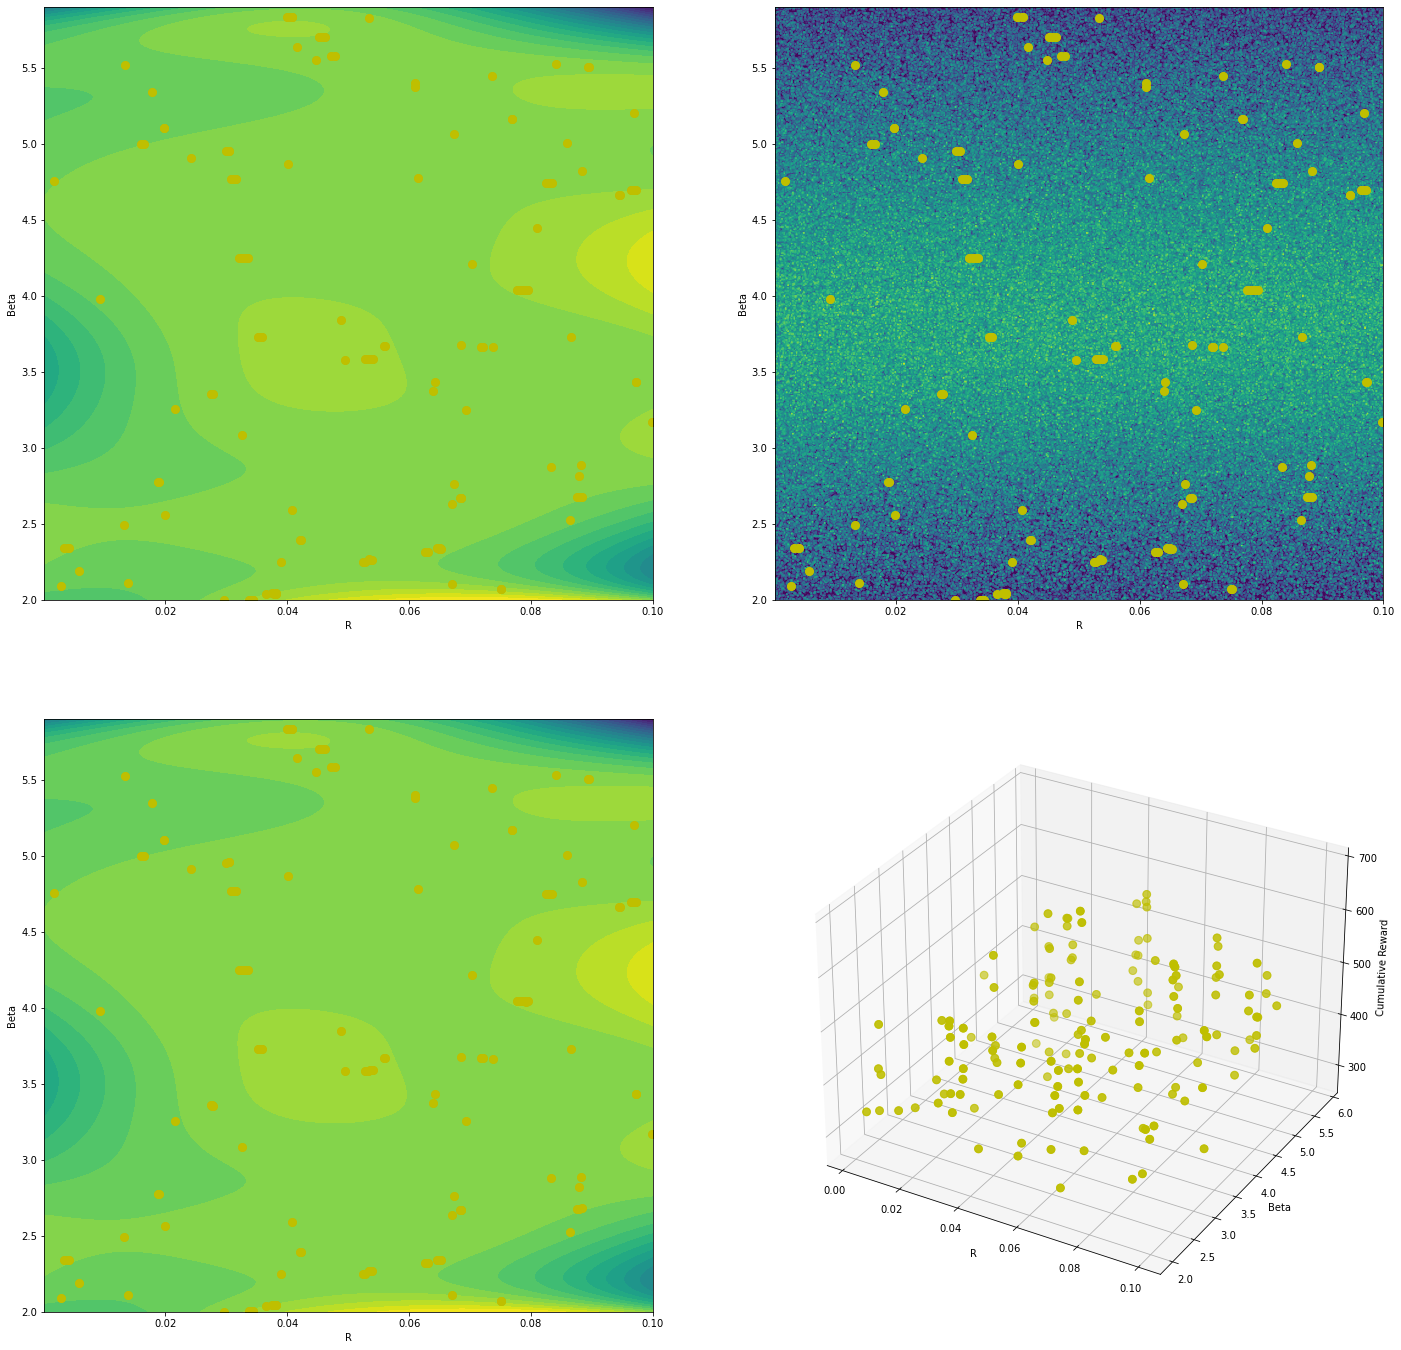

In [49]:
from matplotlib import pyplot as plt
from matplotlib import cm
import matplotlib as mpl
import seaborn as sns
# sns.set()

from bayes_opt import UtilityFunction

fig = plt.figure()

ax = fig.add_subplot(221)#, projection = '3d')

ax.set_xlabel("R")
ax.set_ylabel("Beta")
# ax.set_zlabel("Cumulative Reward")
ticks = 500
R_x = np.linspace(0.0001, 0.1, ticks)
B_y = np.linspace(2.0, 5.9, ticks)
X, Y = np.meshgrid(R_x, B_y)
xy = np.vstack([X.flatten(), Y.flatten()]).T
RB = np.vstack([R_obs, B_obs]).T
# optimizer._gp.fit(RB, y_obs)
mu, sigma = gp.predict(xy, return_std=True)
Z = mu.reshape(ticks, ticks)
nbins=30
levels=mpl.ticker.MaxNLocator(nbins=nbins).tick_values(Z.min(),Z.max())
ax.contourf(X, Y, Z, levels=levels)
ax.scatter(R_obs, B_obs, c='y', s=60)

ax = fig.add_subplot(222)
Z = sigma.reshape(ticks, ticks)
nbins=30
levels=mpl.ticker.MaxNLocator(nbins=nbins).tick_values(Z.min(),Z.max())
ax.contourf(X, Y, Z, levels=levels)
ax.scatter(R_obs, B_obs, c='y', s=60)
ax.set_xlabel("R")
ax.set_ylabel("Beta")

ax = fig.add_subplot(223)
# ax.set_xlabel("R")
# ax.set_ylabel("Beta")
# ax.set_zlabel("Cumulative Reward")
ax.scatter(R_obs, B_obs, c='y', s=60)
utility_function = UtilityFunction(kind="ucb", kappa=5, xi=0)
utility = utility_function.utility(xy, gp, 0)
Z = utility.reshape(ticks, ticks)
nbins=30
levels=mpl.ticker.MaxNLocator(nbins=nbins).tick_values(Z.min(),Z.max())
ax.contourf(X, Y, Z, levels=levels)
ax.scatter(R_obs, B_obs, c='y', s=60)
ax.set_xlabel("R")
ax.set_ylabel("Beta")

ax = fig.add_subplot(224, projection = '3d')
ax.set_xlabel("R")
ax.set_ylabel("Beta")
ax.set_zlabel("Cumulative Reward")
ax.scatter(R_obs, B_obs, y_obs, c='y', s=60)
Z = mu.reshape(ticks, ticks)
# wf = ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10)
# surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
#                        linewidth=0, antialiased=False)

fig.set_size_inches(24, 24)

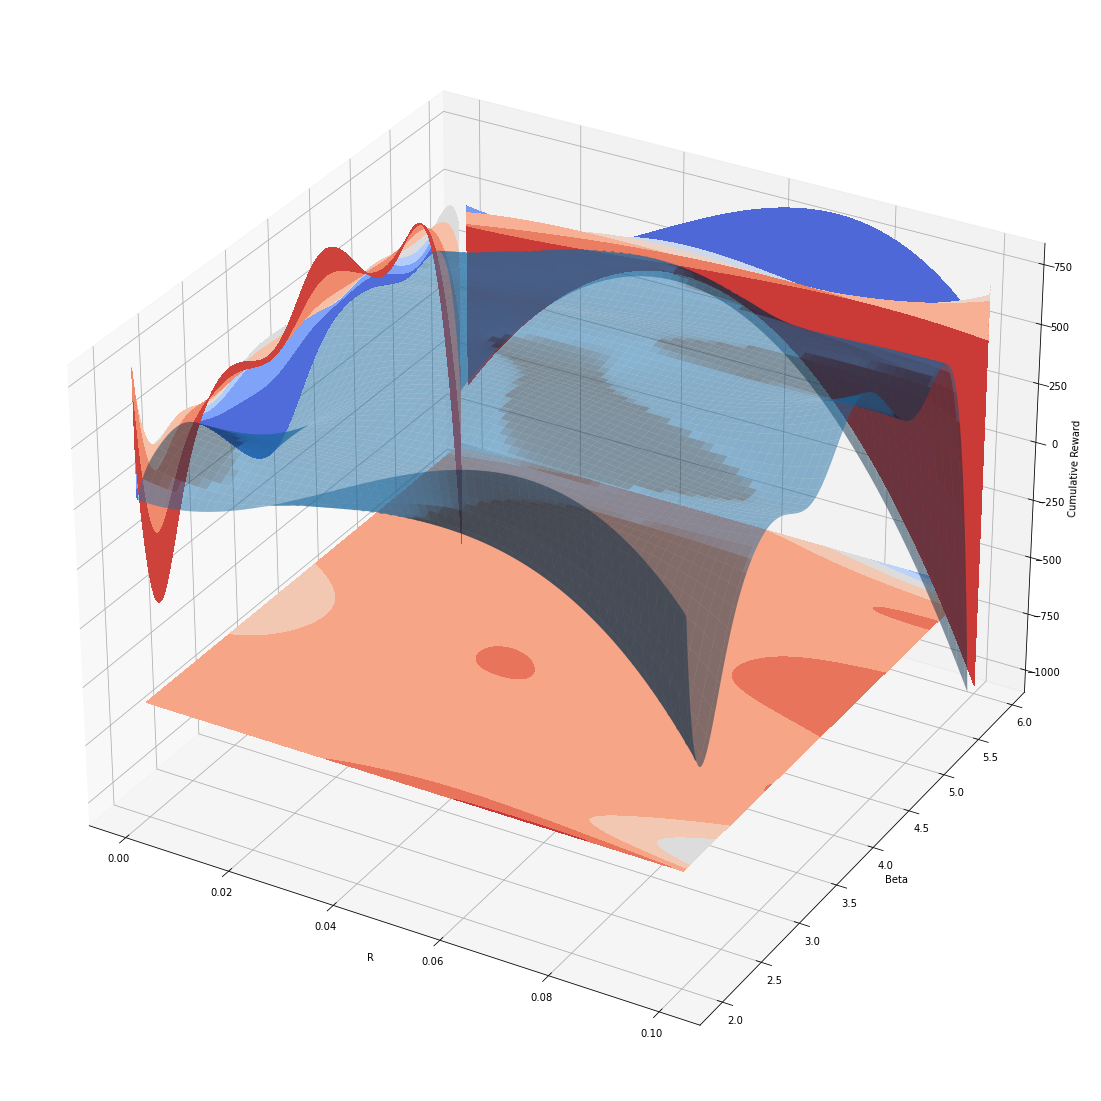

In [48]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.set_xlabel("R")
ax.set_ylabel("Beta")
ax.set_zlabel("Cumulative Reward")
# ax.scatter(R_obs, B_obs, y_obs, c='red', s=60)
Z = mu.reshape(ticks, ticks)

# Plot the 3D surface
ax.plot_surface(X, Y, Z, rstride=8, cstride=8, alpha=0.5)
# cset = ax.contour(X, Y, Z, extend3d=True, cmap=cm.coolwarm)

# Plot projections of the contours for each dimension.  By choosing offsets
# that match the appropriate axes limits, the projected contours will sit on
# the 'walls' of the graph
cset = ax.contourf(X, Y, Z, zdir='z', offset=-600, cmap=cm.coolwarm)
cset = ax.contourf(X, Y, Z, zdir='x', offset=0, cmap=cm.coolwarm)
cset = ax.contourf(X, Y, Z, zdir='y', offset=6, cmap=cm.coolwarm)

fig.set_size_inches(20, 20)


In [62]:
R_x = np.linspace(0.0001, 0.1, 500)
B_y = np.linspace(2.0, 6.0, 500)
X, Y = np.meshgrid(R_x, B_y)
xy = np.vstack([X.flatten(), Y.flatten()]).T
mu, sigma = gp.predict(xy, return_std=True)
xy, mu, sigma, np.mean(mu), np.mean(sigma)

/Users/pehuen/opt/anaconda3/envs/primal2/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


(array([[1.00000000e-04, 2.00000000e+00],
        [3.00200401e-04, 2.00000000e+00],
        [5.00400802e-04, 2.00000000e+00],
        ...,
        [9.95995992e-02, 6.00000000e+00],
        [9.97997996e-02, 6.00000000e+00],
        [1.00000000e-01, 6.00000000e+00]]),
 array([-2.07153402e+02, -2.04630919e+02, -2.02078231e+02, ...,
         2.10344715e-02,  2.09079657e-02,  2.07816791e-02]),
 array([110.01658951, 121.96277579,  84.18642793, ..., 316.22776565,
        316.22776566, 316.22776565]),
 230.6889929509889,
 234.2085830757103)

In [4]:
xy.shape, mu.shape, sigma.shape

((250000, 2), (250000,), (250000,))

In [6]:
np.linspace(-2, 10, 10000).reshape(-1, 1).shape

(10000, 1)